In [1]:
topics_covered_in_here = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting model",
    4: "make predictions and evaluating",
    5: "saving and loading a model",
    6: "putting it all together"
}

topics_covered_in_here

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting model',
 4: 'make predictions and evaluating',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn # nn contains all the building blocks for Neural Networks
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cu124'

## 1. Data (preparing and loading)

Can be spreadsheets, images, videos, audio, DNA, text etc.

ML is a game of 2 parts:
1. Get data into numerical representation
2. Build model to learn patterns in that numerical representations

To showcase these, creating some known data using linear regression

In [3]:
# Parameters *known*
weight = 0.7
bias = 0.3

# creating data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

In [5]:
# train-test- split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

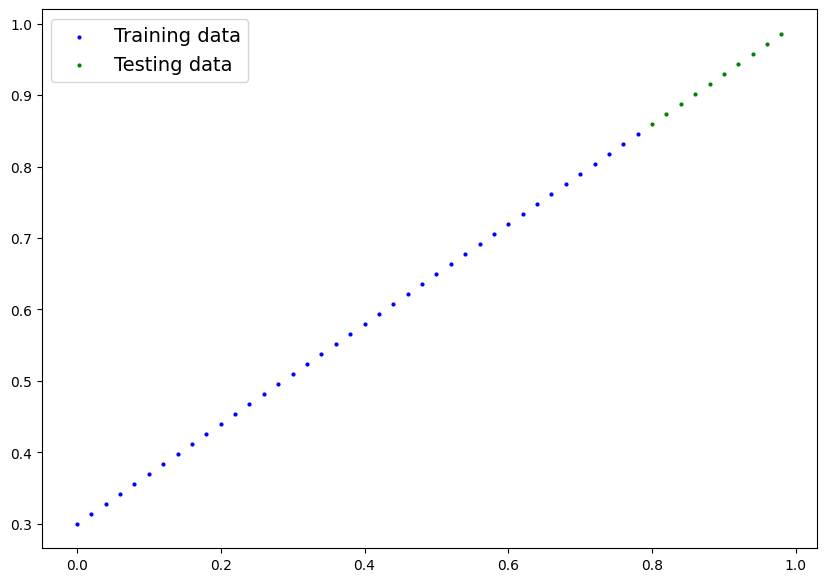

In [7]:
plot_predictions();

## 2. Build model

What our model does is it starts with random values (weight and bias) and then look at training data and adjust the weight and bias to better represent (or get closer to) the ideal values (the weight and bias values we used to create the data)

how does it do so:
two main algorithms:
1. Gradient descent
2. Backpropogation

In [8]:
# creating linear regression model class

class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
  def __init__(self) -> None:
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # start with a random weight
                                            requires_grad=True, # can this parameter be updated via gradient descent?
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, # start with a random bias
                                         requires_grad=True, # can this parameter be updated via gradient descent?
                                         dtype=torch.float))

    # Require forward method to be overridden
    # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
    return self.weights * x + self.bias # y = mx + c

### PyTorch model building essentials

* torch.nn - contains all the buildings for computational graph (a NN can be considered a computational graph)
* torch.nn.Parameter - what parametrs should our model try and learn, often PyTorch layer from torch.nn wil set these for us
* torch.nn.Module - The base class for all NN modules, if you inherit it, must override forward() method
* torch.optim - this is where optimizers in PyTorch are, they will help with gradient descent

In [9]:
# Creating a random seed
torch.manual_seed(42)

# create an instance of the model we created
model_0 = LinearRegressionModel()

# checking parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power

When we pass data to the model, its going to run it through forward method

In [11]:
# make predictions with model - without trainig
with torch.inference_mode(): # inference_mode doesn't track gradient. Because when making predictions you dont need to track gradient to update it later.
  y_preds = model_0(X_test)


# We can also do something similar with with torch.no_grad(), but inference_mode() is preferred
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

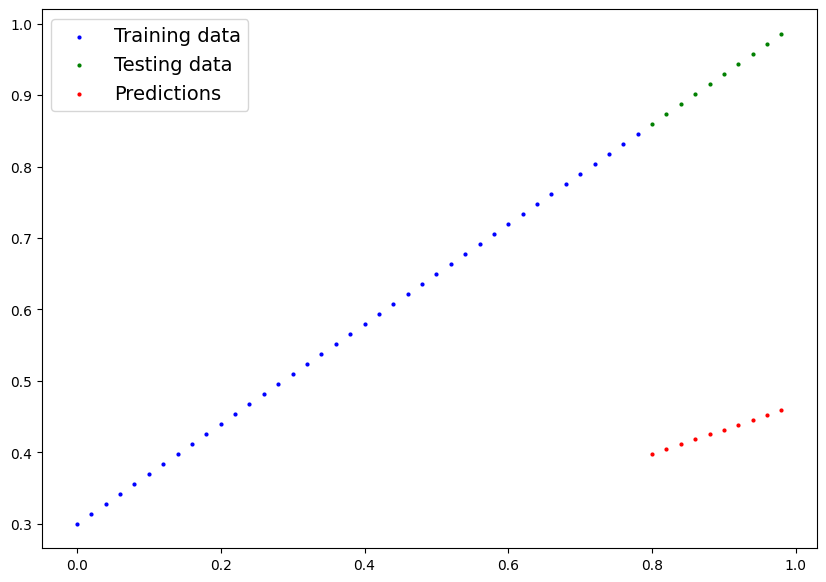

In [12]:
plot_predictions(predictions=y_preds)

### 3. Training the model

The whole idea is to to train a model from unknown paramters to to parameters which better represent the data.

Things needed to trian the data:
* Loss function
* Optimizer

Specifically for PyTorch, we need:
* A training loop
* A testing loop

In [13]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [14]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [15]:
# setup a loss func
loss_fn = nn.L1Loss()

# setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), lr = 0.01) # lr = learning rate = hyperparameter (set by us)

#### Building a training loop and testing in loop in PyTorch

0. Loop through the data
1. forward pass (this invlovesdata moving through our model's `forward()` functions to make predictions - called forward propogation)
2. Calculate the loss (compare forward pass predictions to ground tructh labels)
3. Optimizier zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each paramter of ou model with respect to the loss
5. Optimizer step - use the optimizer to adjust adjust our model parameters to try and improve the loss

In [18]:
# An epoch is one loop through the data
epochs = 200

# Tracking different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# loop through the data:
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # train mode in PyTorch sets all paramaters that require gradients to require gradients. require_grad=True

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  # print(f"Loss: {loss}")

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform Backpropogation on the loss with respect to the parameter of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default the how the optimizer changes will accumulate through the loop so we have to zero them above in step 3 for the next iteration of the loop

  ### Testing
  model_0.eval() # turns off different settings in model which are not needed for evaluation/testing (dropout/batchnorm layers)
  with torch.inference_mode(): # turns off gradient_descent and more things behind the scene
    # 1. Forward pass on test data
    test_pred = model_0(X_test)

    # 2. Calculate loss on test_pred vs y_test
    test_loss = loss_fn(test_pred, y_test)

  # Print out what happened
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch : {epoch}, Loss: {loss}, Test Loss: {test_loss}")
    print(model_0.state_dict())

Epoch : 0, Loss: 0.28983935713768005, Test Loss: 0.4541231691837311
OrderedDict([('weights', tensor([0.3484])), ('bias', tensor([0.1588]))])
Epoch : 10, Loss: 0.1746293306350708, Test Loss: 0.3194132149219513
OrderedDict([('weights', tensor([0.3874])), ('bias', tensor([0.2588]))])
Epoch : 20, Loss: 0.07638873159885406, Test Loss: 0.19773726165294647
OrderedDict([('weights', tensor([0.4258])), ('bias', tensor([0.3463]))])
Epoch : 30, Loss: 0.05069301277399063, Test Loss: 0.13647659122943878
OrderedDict([('weights', tensor([0.4564])), ('bias', tensor([0.3803]))])
Epoch : 40, Loss: 0.04463795945048332, Test Loss: 0.1100495308637619
OrderedDict([('weights', tensor([0.4788])), ('bias', tensor([0.3868]))])
Epoch : 50, Loss: 0.04098063334822655, Test Loss: 0.09699545800685883
OrderedDict([('weights', tensor([0.4974])), ('bias', tensor([0.3833]))])
Epoch : 60, Loss: 0.0375034399330616, Test Loss: 0.08666229248046875
OrderedDict([('weights', tensor([0.5152])), ('bias', tensor([0.3778]))])
Epoch

In [24]:
import numpy as np
np.array(torch.tensor(loss_values).cpu().numpy())

array([0.28983936, 0.17462933, 0.07638873, 0.05069301, 0.04463796,
       0.04098063, 0.03750344, 0.03407188, 0.03063862, 0.02719982,
       0.02376995, 0.020335  , 0.01689645, 0.01346802, 0.01003139,
       0.00659453, 0.00316608, 0.00893248, 0.00893248, 0.00893248],
      dtype=float32)

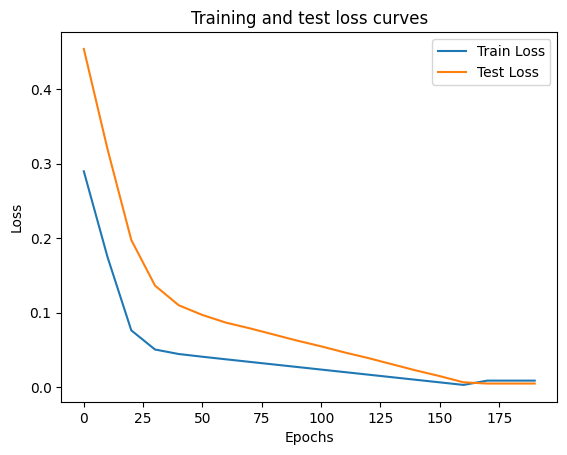

In [25]:
# plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label = "Train Loss")
plt.plot(epoch_count, test_loss_values, label = "Test Loss")
plt.title("Training and test loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [19]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [20]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [21]:
weight, bias

(0.7, 0.3)

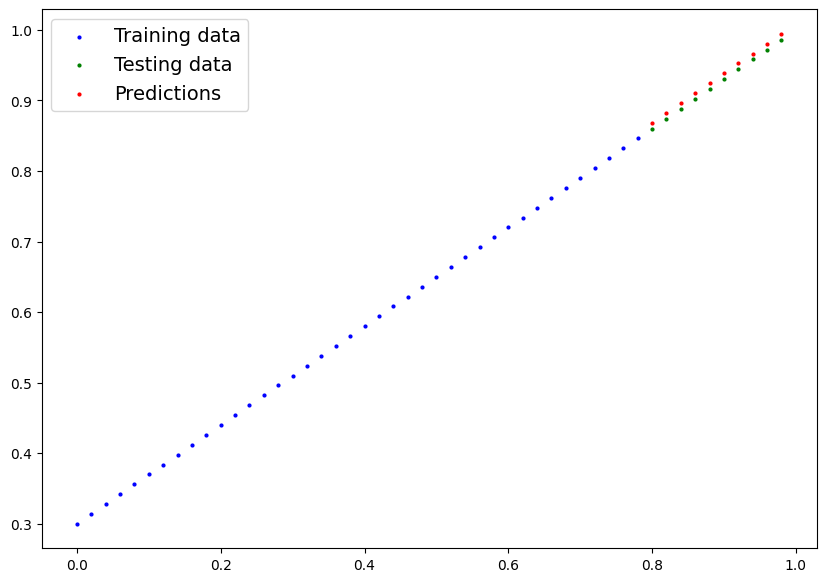

In [22]:
plot_predictions(predictions=y_preds_new)